In [1]:
import sys
sys.path.append("..")
import numpy as np
import torch
from tqdm.notebook import tqdm
from mango.mango import Mango
from mango.utils import plot_loss_reward
from mango.environments import frozen_lake
from mango.actions import grid2d

In [2]:
size = 20
gamma = 0.75

init_kwargs = dict(map_name="RANDOM", shape=(size, size), p=0.8, goal_pos=None, start_pos=(size//2, size//2))
env = frozen_lake.CustomFrozenLakeEnv(**init_kwargs)  # type: ignore
env = frozen_lake.ReInitOnReset(env, **init_kwargs)
env = frozen_lake.TensorObservation(env, one_hot=True)
env_shape = (env.unwrapped.ncol, env.unwrapped.nrow)  # type: ignore

mango = Mango(
    environment=env,
    abstract_actions=[
        grid2d.SubGridMovementOnehot(cell_shape=(2, 2), grid_shape=env_shape, reward=(1 - gamma), invalid_channel=1),
        grid2d.SubGridMovementOnehot(cell_shape=(4, 4), grid_shape=env_shape, reward=(1 - gamma), invalid_channel=1),
    ],
    policy_params=dict(
        lr=1e-3, gamma=gamma,
        net_params=dict(
            hidden_channels=[4, 4], hidden_features=[], activation_out=torch.nn.Tanh(),
            #device=torch.device("cuda") if torch.cuda.is_available() else None,
        ),
    ),
)
mango.reset()
frozen_lake.plot_all_abstractions(mango)

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

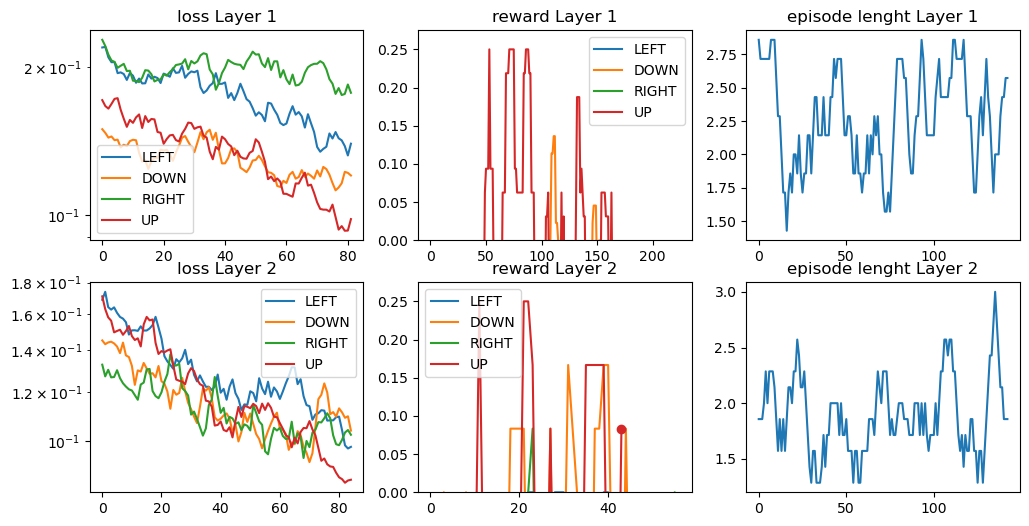

In [ ]:
N = 10000
randomness = np.linspace(1.0, 0.0, N)**2
for layer in [1,2]:
    for r in (pbar := tqdm(randomness)):
        pbar.set_description(f"randomness: {r:.3f}")
        mango.set_randomness(r, layer=layer)
        obs, reward, term, trunc, info = mango.explore(layer=layer, episode_length=3)
        mango.train(layer=layer)
plot_loss_reward(mango, grid2d.Actions, reward_lims=(0, 1.1*(1-gamma)))
mango.save_to("trained_models/frozen_lake/mango_sparse.pickle")

In [ ]:
obs, info = mango.reset()
frozen_lake.plot_all_qvals(mango)

Error in callback <function flush_figures at 0x000001FEC1164280> (for post_execute):


KeyboardInterrupt: 

LEFT
DOWN
RIGHT
UP


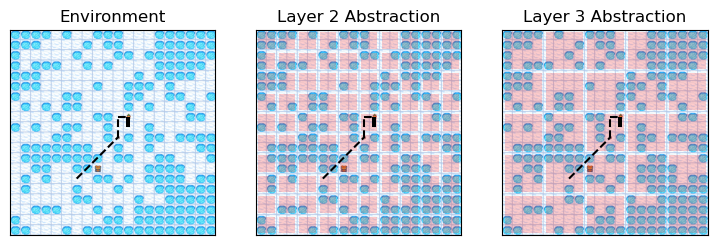

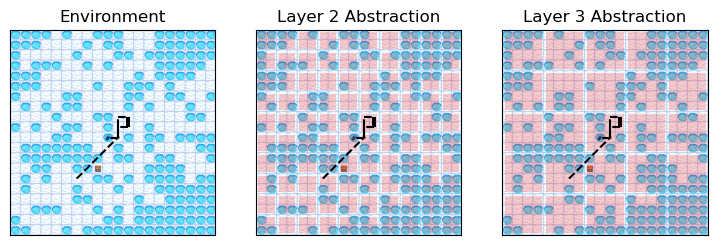

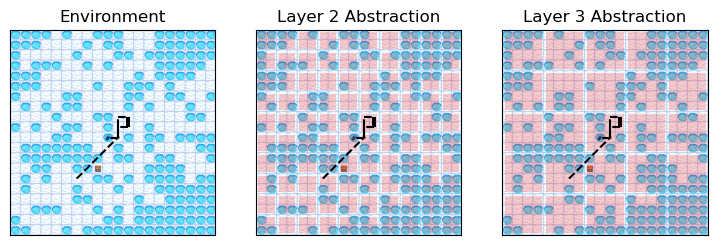

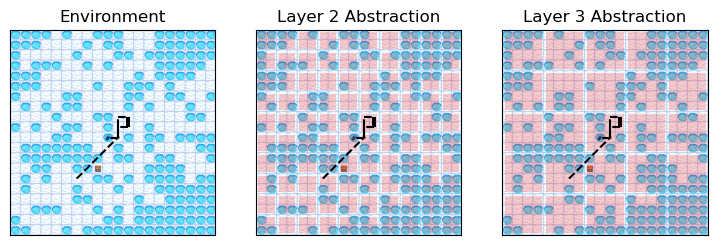

In [ ]:
trajectory = [obs]
for action in grid2d.Actions:
    print(action.name)
    for step in range(10):
        obs, reward, trunc, term, info = mango.step((-1, action.value))
        trajectory.extend(info["mango:trajectory"])
        if not info["mango:truncated"]:
            break
    frozen_lake.plot_all_abstractions(mango, trajectory)